In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import pyemma
import os
import scipy.optimize
import scipy.interpolate

print(os.getcwd())

/home/ebeyerle/bin/anaconda3/envs/pyemma_tutorials/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


/media/ebeyerle/Emerson/CD_ApA/MSM_eric/0.1


In [2]:
def dist(theta_1,theta_2,phi_1,phi_2):
    '''Function defining the distance along the unit circle between two 
    input polar (theta_1,theta_2) and azimuthal (phi_1,phi_2) coordinates.'''
    
    #Conversion factors
    rdeg=(360.0/(2*np.pi)) #Radians -> degrees
    degr=((2*np.pi)/360.0) #Degrees -> radians
    
    theta_1 *= degr
    theta_2 *= degr
    phi_1 *= degr
    phi_2 *= degr
    
    delta_sigma = rdeg*np.arccos(np.cos(theta_1)*np.cos(theta_2)+np.sin(theta_1)*np.sin(theta_2)*np.cos(phi_1-phi_2))
    return delta_sigma

def removearray(L,arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        #Find the index in the list of the array of interest
        ind += 1
    #Make sure that the array is actually in the list
    if ind != size:
        #If the array is in the list, get rid of it
        #Could probably also use del L[ind] here
        L.pop(ind)
    else:
        raise ValueError('array not found in list.')
        
def summary_stats(time_in_a, time_in_b, n_a2b, n_b2a):
    total_time = time_in_a + time_in_b

    frac_a = (1.0 * time_in_a) / total_time
    frac_b = (1.0 * time_in_b) / total_time

    flux_a2b = (1.0 * n_a2b) / total_time
    flux_b2a = (1.0 * n_b2a) / total_time

    try:
        mfpt_a2b = frac_a / flux_a2b
    except:
        mfpt_a2b = np.nan

    try:
        mfpt_b2a = frac_b / flux_b2a
    except:
        mfpt_b2a = np.nan

    #Multiply the MFPT by both the time between frames (0.2 ps)
    #and the lag time to obtain the MFPT in physical units
    print(step*lag*mfpt_a2b, step*lag*mfpt_b2a)
    return step*lag*mfpt_a2b, step*lag*mfpt_b2a

def calc_stats(d):
    #d here needs to be the metastable trajectory
    niters = d.shape[0]
    
    time_in_a = 0
    time_in_b = 0
    n_a2b = 0
    n_b2a = 0

    tt_a2b = []
    tt_b2a = []

    if d[0] == a_bound:
        time_in_a += 1
        curr_state = 0
    else:
        time_in_b += 1
        curr_state = 1

    for k in range(1, niters):
        #if k % 10000 == 0: print(k)
        if (d[k] == a_bound):
            state = 0
        elif (d[k] == b_bound):
            state = 1
        else:
            state = curr_state #Current state is whichever state the trajectory came from most recently

        if state == 0:
            time_in_a += 1
        else:
            time_in_b += 1

        if state != curr_state:
            if state == 0:
                n_b2a += 1
                tt_b2a.append(k)
            else:
                n_a2b += 1
                tt_a2b.append(k)

        curr_state = state

    return n_a2b, n_b2a, time_in_a, time_in_b, tt_a2b, tt_b2a

/home/ebeyerle/bin/anaconda3/envs/pyemma_tutorials/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


b'Mon Feb 24 17:33:54 PST 2020\n'


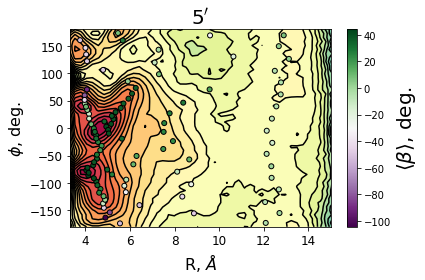

In [55]:
#Now check for dot products

print(subprocess.check_output('date',shell=True))
step = 0.2
bigdplist = []
bigtlist = []
bigacflist = []

nbins = 100
dplist = []
acflist = []
tlist = []
acftimelist = []

twist = np.rad2deg(np.load('Twist.npy'))
dist = 10*np.load('Distance.npy')
roll = np.rad2deg(np.load('Roll.npy')[:,0])

fes = np.load('fes.npy')
ext = [dist.min(), dist.max(), twist.min(), twist.max()]

dtrajs = np.load('100microstates/dtrajs_kmeans.npy').ravel()
dtrajs = dtrajs
lags = (1/step)*np.array([500])
colors1 = plt.cm.cool(np.linspace(0,1,len(lags)))
colors2 = plt.cm.autumn(np.linspace(0,1,len(lags)))
dummy = np.copy(roll)
cc_x = 10*np.load('100microstates/clustercenters_kmeans.npy')[:,0]
cc_y = np.rad2deg(np.load('100microstates/clustercenters_kmeans.npy')[:,1])

M = pyemma.msm.estimate_markov_model(dtrajs,lag=2500)

roll_mapped = np.array([roll[dtrajs == i].mean(0) for i in range(100)])

dlist = []

phi = M.eigenvectors_left()

plt.contourf(fes,zorder=-13,levels=np.linspace(fes.min(),fes.max(),nbins//4),cmap='Spectral',extent=ext)
plt.contour(fes,zorder=-12,levels=np.linspace(fes.min(),fes.max(),nbins//4),colors='k',extent=ext)
im1 = plt.scatter(cc_x,cc_y,c=roll_mapped,cmap='PRGn',s=25,alpha=1.0,edgecolor='k')
cbar=plt.colorbar(im1)
cbar.set_label(r"$\langle\beta\rangle$, deg.",fontsize=20)
plt.xlim((3.3,15))
#plt.ylim((-180,180))
plt.title(r'$5^{\prime}$',fontsize=20)
plt.xlabel(r'R, $\AA$',fontsize=16)
plt.ylabel(r'$\phi$, deg.',fontsize=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('roll_proj_5prime.pdf',dpi=300)
plt.savefig('roll_proj_5prime.png',dpi=300)
plt.show()
plt.close()

b'Mon Feb 24 17:34:11 PST 2020\n'


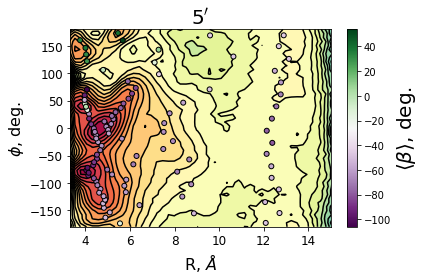

In [56]:
#Now check for dot products

print(subprocess.check_output('date',shell=True))
step = 0.2
bigdplist = []
bigtlist = []
bigacflist = []

nbins = 100
dplist = []
acflist = []
tlist = []
acftimelist = []

twist = np.rad2deg(np.load('Twist.npy'))
dist = 10*np.load('Distance.npy')
roll = np.rad2deg(np.load('Roll.npy')[:,1])

fes = np.load('fes.npy')
ext = [dist.min(), dist.max(), twist.min(), twist.max()]

dtrajs = np.load('100microstates/dtrajs_kmeans.npy').ravel()
dtrajs = dtrajs
lags = (1/step)*np.array([500])
colors1 = plt.cm.cool(np.linspace(0,1,len(lags)))
colors2 = plt.cm.autumn(np.linspace(0,1,len(lags)))
dummy = np.copy(roll)
cc_x = 10*np.load('100microstates/clustercenters_kmeans.npy')[:,0]
cc_y = np.rad2deg(np.load('100microstates/clustercenters_kmeans.npy')[:,1])

M = pyemma.msm.estimate_markov_model(dtrajs,lag=2500)

roll_mapped = np.array([roll[dtrajs == i].mean(0) for i in range(100)])

dlist = []

phi = M.eigenvectors_left()

plt.contourf(fes,zorder=-13,levels=np.linspace(fes.min(),fes.max(),nbins//4),cmap='Spectral',extent=ext)
plt.contour(fes,zorder=-12,levels=np.linspace(fes.min(),fes.max(),nbins//4),colors='k',extent=ext)
im1 = plt.scatter(cc_x,cc_y,c=roll_mapped,cmap='PRGn',s=25,alpha=1.0,edgecolor='k')
cbar=plt.colorbar(im1)
cbar.set_label(r"$\langle\beta\rangle$, deg.",fontsize=20)
plt.xlim((3.3,15))
#plt.ylim((-180,180))
plt.title(r'$5^{\prime}$',fontsize=20)
plt.xlabel(r'R, $\AA$',fontsize=16)
plt.ylabel(r'$\phi$, deg.',fontsize=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('roll_proj_3prime.pdf',dpi=300)
plt.savefig('roll_proj_3prime.png',dpi=300)
plt.show()
plt.close()

In [58]:
extent

[3.0056799, 15.8627243, -179.99961705851285, 179.9998903593811]

In [59]:
metastable_traj.max()

1

In [67]:
#Now check for dot products

twist = np.rad2deg(np.load('Twist.npy'))
dist = 10*np.load('Distance.npy')
data=[np.column_stack([dist,twist])] # Note that the xtc files are saved every 0.2 ps.

nbins=50
hist,x,y = np.histogram2d(data[0][:,0],data[0][:,1], bins=nbins)

dtrajs = np.load('100microstates/dtrajs_kmeans.npy').ravel()


# Making the Markov model
M = pyemma.msm.estimate_markov_model(dtrajs, 2500)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)
print('transition matrix',M.transition_matrix)  # doctest: +SKIP

# Decomposing the Markov State Models into 5 metastates by PCCA+
nmeta=5
M.pcca(nmeta)

extent = [x[0], x[-1], y[0], y[-1]]
pcca_sets = M.metastable_sets
metastable_traj=M.metastable_assignments[dtrajs]

#Interpolate on a grid with 100 bins (PyEMMA default)
nbins=100

#Grid the data and interpolate metastable values based on where the trajectory
#is on the surface. NOTE: method='nearest' rounds to the nearest integer, which
#is what we want since we are trying the pass off the memberships as crisp
#assignments to a single metastable state.
xall=dist
yall=twist
x,y=np.meshgrid(np.linspace(xall.min(),xall.max(),nbins),np.linspace(yall.min(),yall.max(),nbins))
z = scipy.interpolate.griddata(np.column_stack([xall,yall]),metastable_traj,(x,y),method='nearest')

#Make the plot: macrostate decomposition with solid borders
ext=[xall.min(),xall.max(),yall.min(),yall.max()]

#Set the min and max values of the contour plot
vmin = np.min(metastable_traj[metastable_traj > -np.inf])
vmax = np.max(metastable_traj[metastable_traj < np.inf])

fraction of states used =  1.0
fraction of counts used =  1.0
transition matrix [[4.51587934e-02 6.78195594e-04 5.97350048e-04 ... 1.20095828e-04
  1.52576637e-03 1.11699979e-03]
 [5.61568264e-04 3.95186449e-02 1.12062331e-03 ... 8.03436315e-04
  1.48959153e-02 4.19322055e-04]
 [7.02802499e-03 1.59226905e-02 1.10384894e-02 ... 3.39171354e-02
  8.54202123e-03 9.07182607e-04]
 ...
 [5.73658199e-04 4.63478026e-03 1.37701939e-02 ... 1.23057415e-01
  2.90747617e-03 2.38685926e-03]
 [2.02931908e-03 2.39266503e-02 9.65647352e-04 ... 8.09567716e-04
  3.95879951e-02 6.11864572e-04]
 [1.44128407e-02 6.53426296e-03 9.94916919e-04 ... 6.44759907e-03
  5.93593998e-03 3.57938276e-03]]


In [ ]:
# Tools
import scipy as sp
from scipy.optimize import minimize, minimize_scalar, brute
import numpy as np
import math as ma
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg as la
import matplotlib.colors as cols


from scipy import signal as sg
Pi = np.pi
# Time/date stamp runs:
from datetime import datetime as dt

In [ ]:
istate = 5
itslist=[]
#if conc == 0.1:
#    pass
#else:
data=np.load('DisTwist.npy')
dist = 10*data[:,0]
phi = data[:,1]
testdata=np.copy(data) 
print(testdata.shape)
testdata[:,0] = 10*testdata[:,0]
testdata[:,1] = np.rad2deg(testdata[:,1])
ext=[testdata[:,0].min(),testdata[:,0].max(),testdata[:,1].min(),testdata[:,1].max()]
his,dummyx,dummyy = np.histogram2d(testdata[:,0],testdata[:,1],bins=50)
fes = his.T/his.sum()
fes = -np.ma.log(fes)
fes = fes - fes.min()

plt.contour(fes,levels=np.linspace(fes.min(),0.75*fes.max(),20),colors='black',extent=ext,linewidths=1.5,
            linestyles='solid',alpha=1,norm=True)
plt.contourf(fes, levels=np.linspace(fes.min(),0.75*fes.max(),20),
             norm=cols.Normalize(vmin=fes.min(),vmax=0.75*fes.max()),
             cmap='Spectral',extent=ext)
cbar=plt.colorbar()
cbar.set_label(r"Free Energy, $k_BT$",fontsize=20)
cbar.ax.tick_params(labelsize=12)
x,y=np.meshgrid(np.linspace(xall.min(),xall.max(),nbins),np.linspace(yall.min(),yall.max(),nbins))
plt.contour(x, y, z,colors='b',extent=ext)
plt.xlabel(r'R, nm',fontsize=20)
plt.ylabel(r'$\phi$, deg',fontsize=20)
plt.xlim((ext[0],15))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title('Molarity: '+str(conc))
plt.tight_layout()
plt.savefig('MACRO_spectral_fes_all_black_mod.pdf',dpi=300)
plt.savefig('MACRO_spectral_fes_all_black_mod.png',dpi=300)
plt.show()
plt.close()   

b'Mon Feb 24 18:14:45 PST 2020\n'


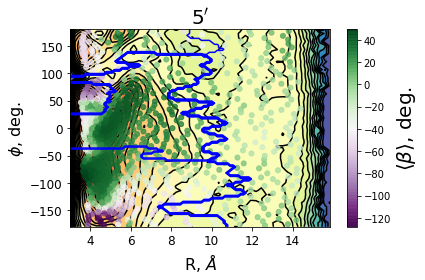

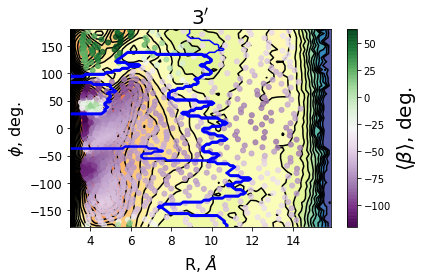

In [86]:
print(subprocess.check_output('date',shell=True))
step = 0.2
bigdplist = []
bigtlist = []
bigacflist = []

nbins = 100
dplist = []
acflist = []
tlist = []
acftimelist = []

roll = np.rad2deg(np.load('Roll.npy')[:,0])

ext = [dist.min(), dist.max(), twist.min(), twist.max()]

dtrajs = np.load('1000microstates/dtrajs_kmeans.npy').ravel()
dtrajs = dtrajs
lags = (1/step)*np.array([500])
colors1 = plt.cm.cool(np.linspace(0,1,len(lags)))
colors2 = plt.cm.autumn(np.linspace(0,1,len(lags)))
dummy = np.copy(roll)
cc_x = 10*np.load('1000microstates/clustercenters_kmeans.npy')[:,0]
cc_y = np.rad2deg(np.load('1000microstates/clustercenters_kmeans.npy')[:,1])

M = pyemma.msm.estimate_markov_model(dtrajs,lag=2500)

roll_mapped = np.array([roll[dtrajs == i].mean(0) for i in range(1000)])

dlist = []

phi = M.eigenvectors_left()

plt.contourf(fes,zorder=-13,levels=np.linspace(fes.min(),fes.max(),nbins//4),cmap='Spectral',extent=ext)
plt.contour(fes,zorder=-12,levels=np.linspace(fes.min(),fes.max(),nbins//4),colors='k',extent=ext)
im1 = plt.scatter(cc_x,cc_y,c=roll_mapped,cmap='PRGn',s=25,alpha=0.8)
cbar=plt.colorbar(im1)
cbar.set_label(r"$\langle\beta\rangle$, deg.",fontsize=20)
plt.contour(x, y, z,colors='b',extent=ext)
plt.xlim((ext[0],ext[1]))
plt.ylim((ext[2],ext[3]))
#plt.xlim((3.3,15))
#plt.ylim((-180,180))
plt.title(r'$5^{\prime}$',fontsize=20)
plt.xlabel(r'R, $\AA$',fontsize=16)
plt.ylabel(r'$\phi$, deg.',fontsize=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('roll_proj_5prime_1000states.pdf',dpi=300)
plt.savefig('roll_proj_5prime_1000states.png',dpi=300)
plt.show()
plt.close()

roll = np.rad2deg(np.load('Roll.npy')[:,1])

fes = np.load('fes.npy')
ext = [dist.min(), dist.max(), twist.min(), twist.max()]

dtrajs = np.load('1000microstates/dtrajs_kmeans.npy').ravel()
dtrajs = dtrajs
lags = (1/step)*np.array([500])
colors1 = plt.cm.cool(np.linspace(0,1,len(lags)))
colors2 = plt.cm.autumn(np.linspace(0,1,len(lags)))
dummy = np.copy(roll)
cc_x = 10*np.load('1000microstates/clustercenters_kmeans.npy')[:,0]
cc_y = np.rad2deg(np.load('1000microstates/clustercenters_kmeans.npy')[:,1])

M = pyemma.msm.estimate_markov_model(dtrajs,lag=2500)

roll_mapped = np.array([roll[dtrajs == i].mean(0) for i in range(1000)])

dlist = []

phi = M.eigenvectors_left()

plt.contourf(fes,zorder=-13,levels=np.linspace(fes.min(),fes.max(),nbins//4),cmap='Spectral',extent=ext)
plt.contour(fes,zorder=-12,levels=np.linspace(fes.min(),fes.max(),nbins//4),colors='k',extent=ext)
im1 = plt.scatter(cc_x,cc_y,c=roll_mapped,cmap='PRGn',s=25,alpha=0.8)
cbar=plt.colorbar(im1)
cbar.set_label(r"$\langle\beta\rangle$, deg.",fontsize=20)
plt.contour(x, y, z,colors='b',extent=ext)
plt.xlim((ext[0],ext[1]))
plt.ylim((ext[2],ext[3]))
#plt.xlim((3.3,15))
#plt.ylim((-180,180))
plt.title(r'$3^{\prime}$',fontsize=20)
plt.xlabel(r'R, $\AA$',fontsize=16)
plt.ylabel(r'$\phi$, deg.',fontsize=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('roll_proj_3prime_1000states.pdf',dpi=300)
plt.savefig('roll_proj_3prime_1000states.png',dpi=300)
plt.show()
plt.close()